# Introduction

In this tutorial we will show how to train a model locally and deploy it to Cognite Model Hosting.

Imagine you have some equipment with temperature and pressure sensors. A key factor to achieving a long lifecycle for this type of equipment is to make sure the friction isn't too high. You can measure the friction, but it's expensive - so you would prefer to avoid it. The physics are known, so you know friction follows the formula `f = b0 + b1*t + b2*p * b3*sqrt(t*p)`. But you don't know the constants `b0, b1, b2, b3`. You decide to measure the friction for two days and then estimate the constants with linear regression. You'll train with data from the first day and validate with data from day two.

**Requirements**:
- You need to have `cognite-model-hosting-notebook`, `pandas`, `scikit-learn` and `matplotlib` installed
- The environment variables `COGNITE_API_KEY` and `COGNITE_CLIENT_NAME` should be set

# Training data

You can use your own data or you can generate some fake data by running the `generate_data.py` script.

In [1]:
# The ids of the time series we will use for training
# NOTE: USE YOUR OWN TIME SERIES OR THOSE YOU GET FROM generate_data.py
ts_ids = {
    'temperature': 6663885396914735,
    'pressure': 782835363770365,
    'friction': 4812982692639282,
}

We'll define our training and validation data in a DataSpec.

In [2]:
from cognite.model_hosting.data_spec import DataSpec, TimeSeriesSpec
from datetime import datetime

training_data_spec = DataSpec(time_series={
    alias: TimeSeriesSpec(
        id=ts_id,
        start=datetime(2019, 3, 1),
        end=datetime(2019, 3, 2),
        aggregate="average",
        granularity="1m",
    )
    for alias, ts_id in ts_ids.items()
})

validation_data_spec = DataSpec(time_series={
    alias: TimeSeriesSpec(
        id=ts_id,
        start=datetime(2019, 3, 2),
        end=datetime(2019, 3, 3),
        aggregate="average",
        granularity="1m",
    )
    for alias, ts_id in ts_ids.items()
})

And then we can use the DataFetcher to fetch the training data and have a look at it.

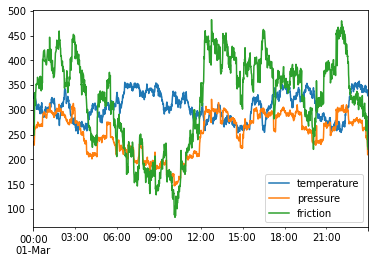

In [3]:
from cognite.model_hosting.data_fetcher import DataFetcher

data_fetcher = DataFetcher(training_data_spec)
df = data_fetcher.time_series.fetch_dataframe(["temperature", "pressure", "friction"])

%matplotlib inline
df.plot()

# Defining the model

Creating a model is quite easy. First we define our requirements. We're going to use `cognite-model-hosting` and `scikit-learn`.

In [4]:
# !requirements
# cognite-model-hosting==0.2.0
# scikit-learn==0.20.3

Then we write code. We need to define three functions: `train_model()`, `load_model()` and `predict()`.

In [5]:
# !model
import pickle
import numpy as np
from sklearn.linear_model import LinearRegression
from cognite.model_hosting.data_fetcher import DataFetcher

In [6]:
def train_model(open_artifact, data_spec):
    data_fetcher = DataFetcher(data_spec)
    df = data_fetcher.time_series.fetch_dataframe(["temperature", "pressure", "friction"])
    
    X = df[["temperature", "pressure"]].copy()
    X["intercept"] = np.ones(len(X))
    X["sqrt_temp_press"] = np.sqrt(X.temperature * X.pressure)
    y = df["friction"]
    
    regressor = LinearRegression()
    regressor.fit(X, y)
    
    with open_artifact("regressor.pkl", "wb") as f:
        pickle.dump(regressor, f)

In [7]:
# !model
def load_model(open_artifact):
    with open_artifact("regressor.pkl", "rb") as f:
        return pickle.load(f)

def predict(model, instance):
    regressor = model
    
    data_fetcher = DataFetcher(instance, client_name="tutorial-client")
    df = data_fetcher.time_series.fetch_dataframe(["temperature", "pressure"])
    X = df[["temperature", "pressure"]]
    X["intercept"] = np.ones(len(X))
    X["sqrt_temp_press"] = np.sqrt(X.temperature * X.pressure)
    
    predicted_friction = regressor.predict(X)
    return list(predicted_friction)

We simply mark every cell we want included in the model with `# !model`. We don't include the `train_model()` function since we'll do training locally in this tutorial.

Our `train_model()` function must have `open_artifact` as it's first parameter. The second parameter is user-defined. `open_artifact` is just like the builtin function `open()`. It can be used to read and write files. But `open_artifact()` points to a storage location specific for the artifacts of a single model version. When you train locally this will just be a folder on your machine, while when you train in Model Hosting this will be a special cloud storage location.

The purpose of `load_model()` is to load our model from the artifact storage - from where it was written in `train_model`. It's first parameter must be `open_artifact`.

The `predict()` method must take `model` as the first parameter and `instance` as second. The `model` parameter is whatever `load_model` returns and can be an arbitrary Python value, but is in this case an instance of LinearRegression (our trained regressor). `instance` is the value to do prediction on. We have here assumed the user will pass in a data spec as instance, but it can be whatever you want as long as it's JSON serializable.

Okay, let's train our model locally.

In [8]:
from cognite.model_hosting.notebook import local_artifacts

train_model(local_artifacts("tutorial-friction"), training_data_spec)

That's it! `local_artifacts()` creates a version of `open_artifact` that points the folder `artifacts/<name>/`. So you will find the artifacts created during training in the folder `artifacts/tutorial-friction/` - check it out!

# Testing locally

Before we deploy this to Model Hosting we can try out prediction locally on our validation data.

In [9]:
model = load_model(local_artifacts("tutorial-friction"))
predictions = predict(model, validation_data_spec)

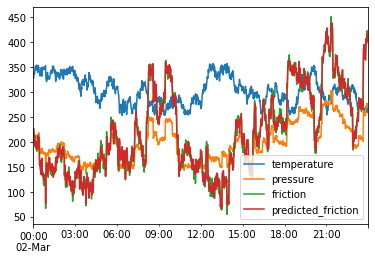

In [10]:
data_fetcher = DataFetcher(validation_data_spec)
df = data_fetcher.time_series.fetch_dataframe(["temperature", "pressure", "friction"])
df["predicted_friction"] = predictions

%matplotlib inline
df.plot()

Looks good (almost perfect actually - that's because we use fake data in this tutorial).
If this was a real use case we would probably do more than just plot the predictions, but we will leave it at that and turn our focus on how to deploy.

# Deploy our model

In [11]:
from cognite.client.experimental import CogniteClient
from cognite.model_hosting.notebook import deploy_model_version

model_hosting = CogniteClient().model_hosting

Before we can deploy a model version we must have a model.

In [12]:
model_name = "tutorial-friction"
model_hosting.models.create_model(model_name)

And then we deploy this notebook and our trained model as a model version. It's important you **save the notebook** before doing this since the notebook file will be read to find your model. Note that we specify the folder we saved artifacts to during training. All artifacts/files in this folder are uploaded.

In [13]:
model_version_name = "tutorial-friction-v1"
deploy_model_version(
    model_name=model_name,
    version_name=model_version_name,
    runtime_version="0.1",
    artifacts_directory="artifacts/tutorial-friction",
)

Now we just have to wait for the deployment to finish. This usually takes a few minutes. Notice that the next step won't work before the status of the model version is 'READY'.

In [14]:
model_hosting.versions.get_model_version(model_name, model_version_name).status

'READY'

# Testing the model

Now that it's deployed we can test it out. Let's perform the same prediction as we did locally - on the validation data.

In [15]:
predictions = model_hosting.models.online_predict(model_name, model_version_name, instances=[validation_data_spec])[0]

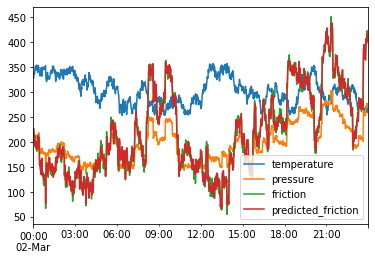

In [16]:
data_fetcher = DataFetcher(validation_data_spec)
df = data_fetcher.time_series.fetch_dataframe(["temperature", "pressure", "friction"])
df["predicted_friction"] = predictions

%matplotlib inline
df.plot()

Same result as we got locally! It's important to note that these predictions were performed in Cognite Model Hosting in the cloud, not on your computer. Anyone with internet (and appropriate access rights) can now access this model!

When you're done - remember to clean up after yourself:

In [17]:
source_package_id = model_hosting.versions.get_model_version(model_name, model_version_name).source_package_id
model_hosting.models.delete_model(model_name)
model_hosting.source_packages.delete_source_package(source_package_id)